Cuma buat data cleaning

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from collections import Counter
import string
import re
# from mpstemmer import MPStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report

In [11]:
# prompt: connect my dataset in Drive in this path (DatasetTweets-PPKM_Labeled.csv)

import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Replace 'Your Folder Path' with the actual path to your CSV file in Google Drive
file_path = '/content/drive/My Drive/Dataset/Tweets-PPKM_Labeled.csv'

df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip', encoding='latin-1')  # or encoding='utf-8' or 'iso-8859-1'

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,User,Tweet,sentiment
0,2022-03-31 14:32:04+00:00,pikobar_jabar,Ketahui informasi pembagian #PPKM di wilayah J...,1
1,2022-03-31 09:26:00+00:00,inewsdotid,Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...,1
2,2022-03-31 05:02:34+00:00,vdvc_talk,"Juru bicara Satgas Covid-19, Wiku Adisasmito m...",1
3,2022-03-30 14:23:10+00:00,pikobar_jabar,Ketahui informasi pembagian #PPKM di wilayah J...,1
4,2022-03-30 11:28:57+00:00,tvOneNews,Kementerian Agama menerbitkan Surat Edaran Nom...,1


hapus kolom yg ga kepake (date, user)

In [12]:
df.drop(columns=["Date", "User"], inplace=True)
df.head()

,Tweet,sentiment
0,Ketahui informasi pembagian #PPKM di wilayah J...,1
1,Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...,1
2,"Juru bicara Satgas Covid-19, Wiku Adisasmito m...",1
3,Ketahui informasi pembagian #PPKM di wilayah J...,1
4,Kementerian Agama menerbitkan Surat Edaran Nom...,1


lowercase

In [13]:
df["Tweet"] = df["Tweet"].str.lower()
df.head()


,Tweet,sentiment
0,ketahui informasi pembagian #ppkm di wilayah j...,1
1,tempat ibadah di wilayah ppkm level 1 boleh be...,1
2,"juru bicara satgas covid-19, wiku adisasmito m...",1
3,ketahui informasi pembagian #ppkm di wilayah j...,1
4,kementerian agama menerbitkan surat edaran nom...,1


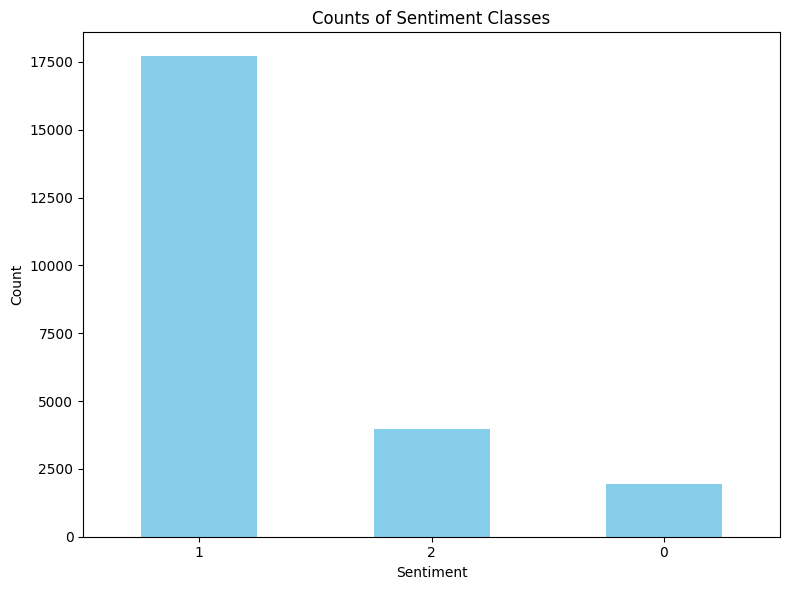

In [14]:
sentiment_counts = df['sentiment'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Counts of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [21]:
!pip install levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.4 MB/s eta 0:00:00


In [22]:
from mpstemmer import MPStemmer

def remove_hashtags(text):
    tokens = text.split()
    tokens_without_hashtags = [token for token in tokens if not token.startswith("#")]
    return " ".join(tokens_without_hashtags)

def remove_refs(text):
    tokens = text.split()
    tokens_without_hashtags = [token for token in tokens if not token.startswith("@")]
    return " ".join(tokens_without_hashtags)

def remove_links(text):
    tokens = text.split()
    tokens_without_hashtags = [token for token in tokens if not "http" in token]
    return " ".join(tokens_without_hashtags)

def remove_puncs(text):
    for char in string.punctuation:
        text = text.replace(char, "")
    return " ".join(text.split())

def remove_emojis(text):
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoji, '', text)

stemmer = MPStemmer()

example = "lets #go #EDM, ... @lifeatedelab yuhu https://twitter.com 😊😊😊 masa ngga"

print(remove_hashtags(example))
print(remove_refs(example))
print(remove_links(example))
print(remove_puncs(example))
print(remove_emojis(example))
print(stemmer.stem_kalimat(example))

lets ... @lifeatedelab yuhu https://twitter.com 😊😊😊 masa ngga
lets #go #EDM, ... yuhu https://twitter.com 😊😊😊 masa ngga
lets #go #EDM, ... @lifeatedelab yuhu 😊😊😊 masa ngga
lets go EDM lifeatedelab yuhu httpstwittercom 😊😊😊 masa ngga
lets #go #EDM, ... @lifeatedelab yuhu https://twitter.com  masa ngga
lets #go #edm, ... @lifeatedelab yuhu https://twitter.com 😊😊😊 masa tidak


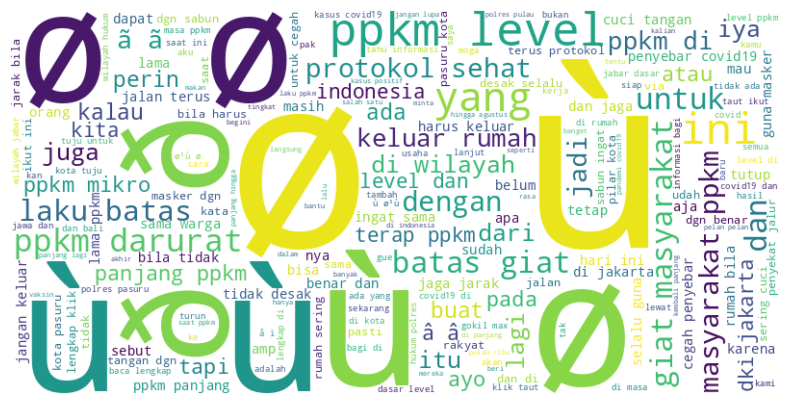

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_counts = Counter()

df['Tweet'] = df['Tweet'].apply(lambda x: remove_hashtags(x))
df['Tweet'] = df['Tweet'].apply(lambda x: remove_refs(x))
df['Tweet'] = df['Tweet'].apply(lambda x: remove_links(x))
df['Tweet'] = df['Tweet'].apply(lambda x: remove_puncs(x))
df['Tweet'] = df['Tweet'].apply(lambda x: remove_emojis(x))
df['Tweet'] = df['Tweet'].apply(lambda x: stemmer.stem_kalimat(x))

df['Tweet'].str.split().apply(word_counts.update)

text = ' '.join(df['Tweet'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [26]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.0 MB/s eta 0:00:00


In [27]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Create stopword remover
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

# Apply stopword removal to the 'Tweet' column
df['Tweet'] = df['Tweet'].apply(lambda x: stopword_remover.remove(x))

In [28]:
# prompt: berikan contoh hasil stopword removal

# Example usage of stopword removal
example_sentence = "ini adalah contoh kalimat untuk uji coba stopword removal"
removed_stopwords = stopword_remover.remove(example_sentence)
print(f"Original sentence: {example_sentence}")
print(f"Sentence after stopword removal: {removed_stopwords}")

Original sentence: ini adalah contoh kalimat untuk uji coba stopword removal
Sentence after stopword removal: adalah contoh kalimat uji coba stopword removal


In [29]:
# prompt: lakukan Stemming and Lemmatization

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# lemmatization (using stemmer as a proxy since Sastrawi doesn't have a dedicated lemmatizer)
df['Tweet'] = df['Tweet'].apply(lambda x: stemmer.stem(x))

In [30]:
# prompt: lakukan uji stemming pada salah satu data tweet secara acak

# Get a random tweet index
random_index = np.random.randint(0, len(df))

# Get the random tweet
random_tweet = df['Tweet'][random_index]

# Apply stemming to the random tweet
stemmed_tweet = stemmer.stem(random_tweet)

# Print the original and stemmed tweet
print("Original tweet:", random_tweet)
print("Stemmed tweet:", stemmed_tweet)

Original tweet: terap ppkm mikro upaya partisipatif gotong royong semua elemen masyarakat upaya dalam rangka atas mememenah laju tular covid19 lebih cepat
Stemmed tweet: terap ppkm mikro upaya partisipatif gotong royong semua elemen masyarakat upaya dalam rangka atas mememenah laju tular covid19 lebih cepat


In [31]:
# prompt: hapus baris jika terdapat data yang kosong, lalu hapus duplikasi data, dan kemudiam hapus karakter yang tidak perlu

# Drop rows with empty data in the 'Tweet' column
df.dropna(subset=['Tweet'], inplace=True)

# Remove duplicate rows based on the 'Tweet' column
df.drop_duplicates(subset=['Tweet'], inplace=True)

# Further cleaning: Remove non-alphanumeric characters except spaces
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z0-9 ]', '', regex=True)

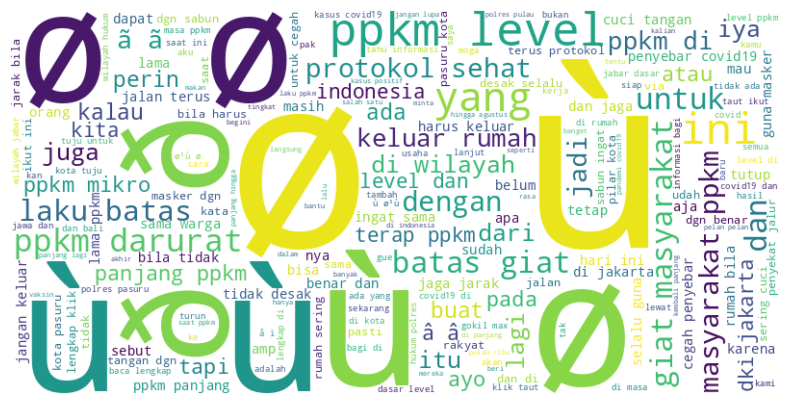

In [32]:
# prompt: lakukan display word

# Assuming 'wordcloud' object is already created as in your provided code

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

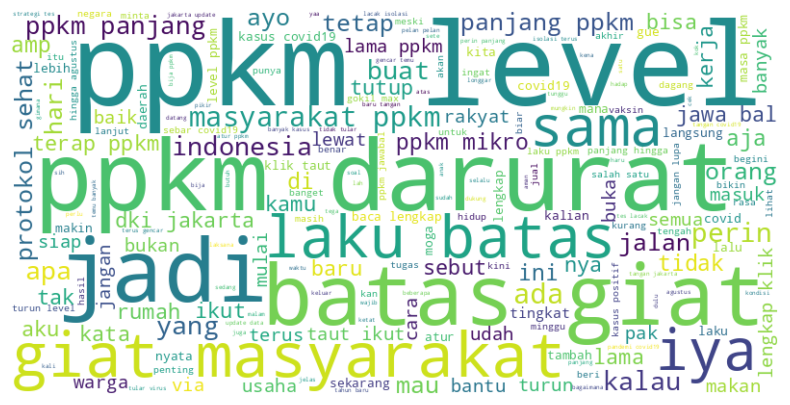

In [33]:
# prompt: mengapa saya masih menemukan karakter seperti ini (Ú, ð, Ø), hapus saja karakter sepeti itu dari data, dan lakukan word display

import re

def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7F]+', '', text)

# ... (your existing code)

df['Tweet'] = df['Tweet'].apply(remove_non_ascii)

# ... (rest of your code)

word_counts = Counter()
for tweet in df['Tweet']:
    word_counts.update(tweet.split())

# Generate WordCloud
text = ' '.join(df['Tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [34]:
# prompt: simpan dataset yang bersih ini menjadi "cnn-sentiment-twitter-cleaned.csv" lakukan dengan format csv pada dataset, dengan separator menggunakan koma","

df.to_csv('cnn-sentiment-twitter-cleaned.csv', sep=',', index=False)